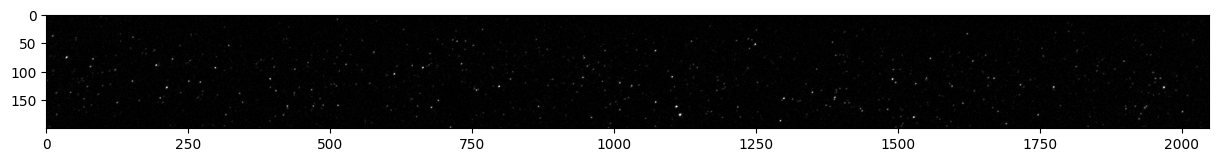

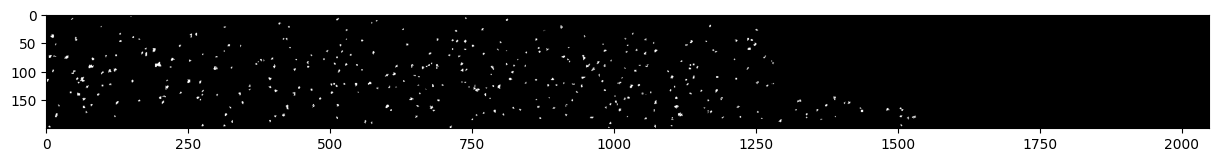

In [1]:
# Set proper path
import os
current_dir = os.getcwd()
if "notebooks" in current_dir:
    current_dir = os.chdir("../")

# Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from src.data.build_mask import build_mask

# Replace 'path_to_your_image' with the actual path to your image (relative to the root of the project)
image_path = 'data/interim/batch1/cam0/B00002.png'

# Open the image file
img = Image.open(image_path)

# make it a numpy array
img = np.array(img)

# Plot the image in big format
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')
plt.show()

json_path = "src/data/data_labeller/project-2-at-2023-11-20-14-43-f6f813f4.json"
mask = build_mask(json_path)

# Plot mask
plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray')
plt.show()

### MASKS IN SEQUENCE WITH IMAGE BEFORE AND AFTER

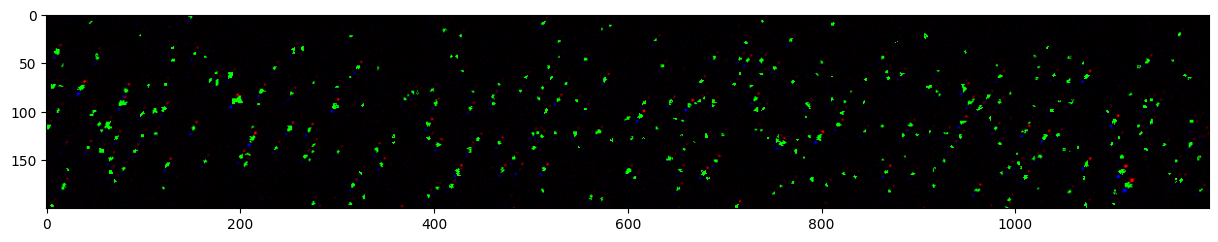

In [2]:
img1_path = 'data/interim/batch1/cam0/B00001.png'
img3_path = 'data/interim/batch1/cam0/B00003.png'

# Stack img1, ar2 and img3 as a three channel image
img1 = Image.open(img1_path)
img1 = np.array(img1)

img3 = Image.open(img3_path)
img3 = np.array(img3)

# Stack the images
img_stacked = np.stack((img1, mask, img3), axis=-1)

# Plot the image in big format
plt.figure(figsize=(15, 15))
plt.imshow(img_stacked.astype("int")[:,:1200,:])
plt.show()

### PARTICLES FILTERED BY MASK

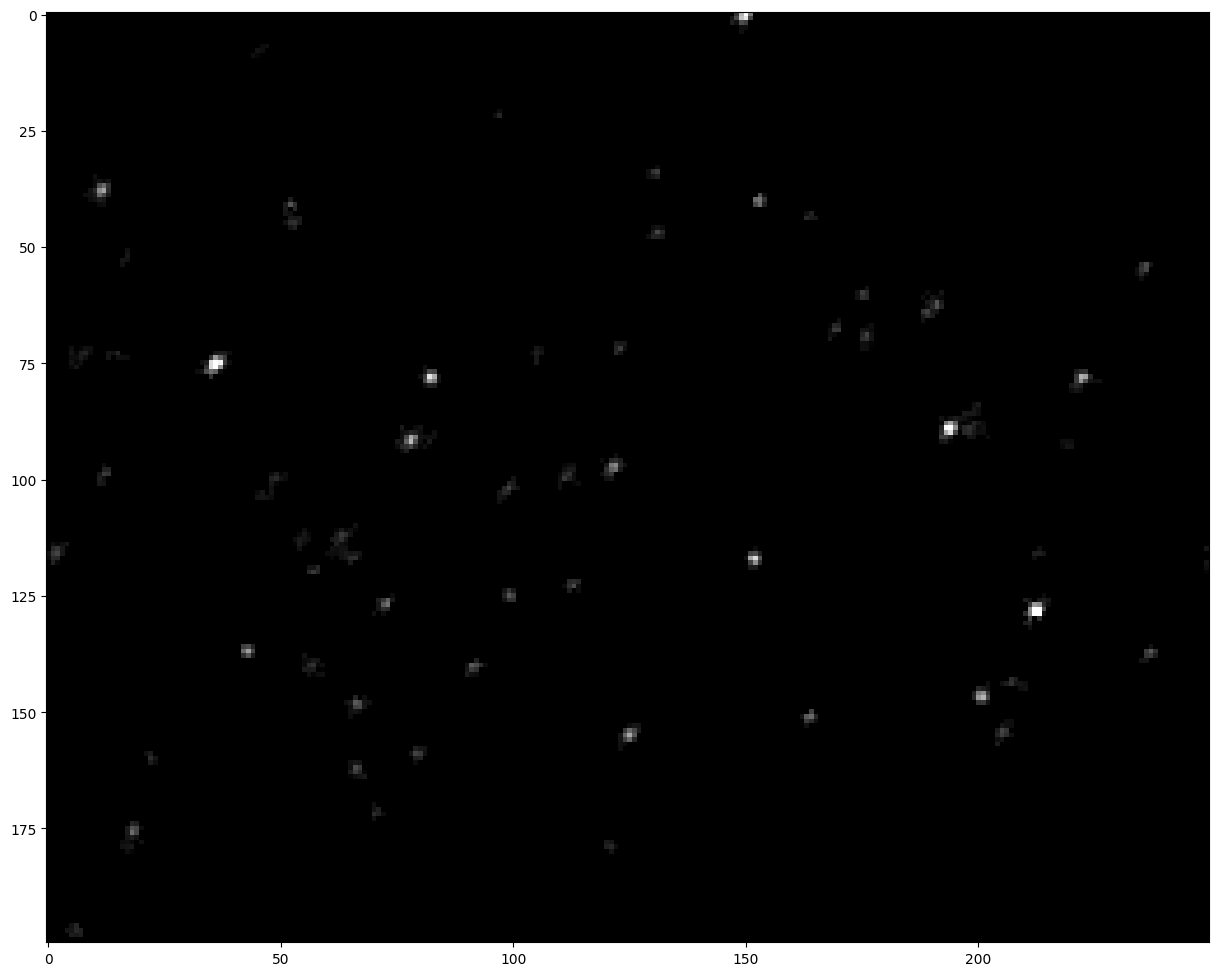

In [3]:
# Load image 2 filtered by mask
img2_path = 'data/interim/batch1/cam0/B00002.png'
img2 = Image.open(img2_path)
img2 = np.array(img2)

# Plot the image in big format
plt.figure(figsize=(15, 15))
plt.imshow((img2*mask)[:,:250], cmap='gray')
plt.show()